# PPO Model Testing

Evaluate a trained PPO+JEPA model using a single training config file.


In [3]:
from __future__ import annotations

import os
import sys
import io
import zipfile
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List
import matplotlib.pyplot as plt
import copy

import numpy as np
import pandas as pd
import torch

# Resolve project root robustly when notebook is launched from different cwd
def find_project_root(start: Path) -> Path:
    p = start.resolve()
    for candidate in [p, *p.parents]:
        if (candidate / "src").exists() and (candidate / "configs").exists():
            return candidate
    raise RuntimeError("Could not locate project root containing src/ and configs/")

PROJECT_ROOT = find_project_root(Path.cwd())
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
if str(PROJECT_ROOT / "src") not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT / "src"))

from config.config_utils import load_json_config
from Datasets.multi_asset_dataset import Dataset_Finance_MultiAsset
from Training.sb3_jepa_ppo import JEPAAuxFeatureExtractor, PPOWithJEPA
from models.jepa.jepa import JEPA
from models.time_series.patchTransformer import PatchTSTEncoder

print(f"Project root: {PROJECT_ROOT}")


Project root: C:\python\koulu\Gradu


In [4]:
# -----------------------------
# User parameters
# -----------------------------
# Config used for training this PPO model
PPO_CONFIG_PATH = "configs/ppo_jepa_final_1.json"

# Optional overrides (set to None to auto-resolve from config)
PPO_CHECKPOINT_PATH = None
# Optional: used only for asset_universe lookup, not for JEPA model weights
JEPA_CHECKPOINT_PATH = None

# If None, evaluate all assets available in validation split
MAX_ASSETS = None

# Deterministic policy during evaluation
DETERMINISTIC = True
# Optional log directories for visualization (None = auto-resolve from config/model_name)
TRAIN_LOG_DIR = str(PROJECT_ROOT / "logs" / "jepa6_ppo_final1_0")
EVAL_LOG_DIR = str(PROJECT_ROOT / "logs" / "jepa6_ppo_final1_eval")



In [5]:
def get_latest_ppo_checkpoint(checkpoint_dir: str) -> str | None:
    if not os.path.isdir(checkpoint_dir):
        return None
    ckpts = []
    for fname in os.listdir(checkpoint_dir):
        if fname.startswith("ppo_") and fname.endswith("_steps.zip"):
            ckpts.append(os.path.join(checkpoint_dir, fname))
    if not ckpts:
        return None
    ckpts.sort(key=lambda p: os.path.getmtime(p))
    return ckpts[-1]


def load_tickers(path: str) -> list | None:
    if not path or not os.path.exists(path):
        return None
    with open(path, "r", encoding="utf-8") as f:
        tickers = [line.strip() for line in f if line.strip()]
    return tickers or None


def load_asset_universe_from_checkpoint(path: str | None) -> list | None:
    if not path or not os.path.exists(path):
        return None
    try:
        checkpoint = torch.load(path, map_location="cpu")
    except Exception:
        return None
    asset_universe = checkpoint.get("asset_universe")
    return list(asset_universe) if asset_universe else None


cfg = load_json_config(str(PROJECT_ROOT / PPO_CONFIG_PATH), "", str(PROJECT_ROOT / "notebooks" / "ppo_model_test.ipynb"))

model_name = cfg["model_name"]
paths_cfg = cfg["paths"]
dataset_cfg = cfg["dataset"]
env_cfg = cfg["env"]
ppo_cfg = cfg["ppo"]
jepa_cfg = cfg["jepa_model"]

checkpoint_root = paths_cfg.get("checkpoint_root", "checkpoints")
log_root = paths_cfg.get("log_root", "logs")
ppo_checkpoint_dir = str(PROJECT_ROOT / checkpoint_root / model_name)

# PPO checkpoint is selected after log visualization.
if PPO_CHECKPOINT_PATH is not None and not os.path.isabs(PPO_CHECKPOINT_PATH):
    PPO_CHECKPOINT_PATH = str(PROJECT_ROOT / PPO_CHECKPOINT_PATH)

if JEPA_CHECKPOINT_PATH is None and paths_cfg.get("jepa_checkpoint_dir"):
    jepa_checkpoint_dir = paths_cfg["jepa_checkpoint_dir"]
    JEPA_CHECKPOINT_PATH = str(PROJECT_ROOT / jepa_checkpoint_dir / "best.pt")
if JEPA_CHECKPOINT_PATH is not None and not os.path.isabs(JEPA_CHECKPOINT_PATH):
    JEPA_CHECKPOINT_PATH = str(PROJECT_ROOT / JEPA_CHECKPOINT_PATH)

ACTION_MODE = env_cfg.get("action_mode", "continuous")
ALLOW_SHORT = env_cfg.get("allow_short", True)
INCLUDE_WEALTH = env_cfg.get("include_wealth", True)
INCLUDE_ASSET_ID = env_cfg.get("include_asset_id", True)
TRANSACTION_COST = float(
    env_cfg.get("transaction_cost_end", env_cfg.get("transaction_cost", env_cfg.get("transaction_cost_start", 0.0)))
)

print("Model name:", model_name)
print("PPO checkpoint (pre-selection):", PPO_CHECKPOINT_PATH)
print("JEPA checkpoint:", JEPA_CHECKPOINT_PATH)
print("Action mode:", ACTION_MODE)
print("Asset universe:", paths_cfg["asset_universe_path"])


Model name: jepa6_ppo_final1
PPO checkpoint (pre-selection): None
JEPA checkpoint: C:\python\koulu\Gradu\checkpoints\jepa_initial6\best.pt
Action mode: discrete_3
Asset universe: None


## Training and Eval Log Visualization
Use this section to inspect the training run and identify the best checkpoint.


Train log dir: C:\python\koulu\Gradu\logs\jepa6_ppo_final1_0
Eval log dir:  C:\python\koulu\Gradu\logs\jepa6_ppo_final1_eval


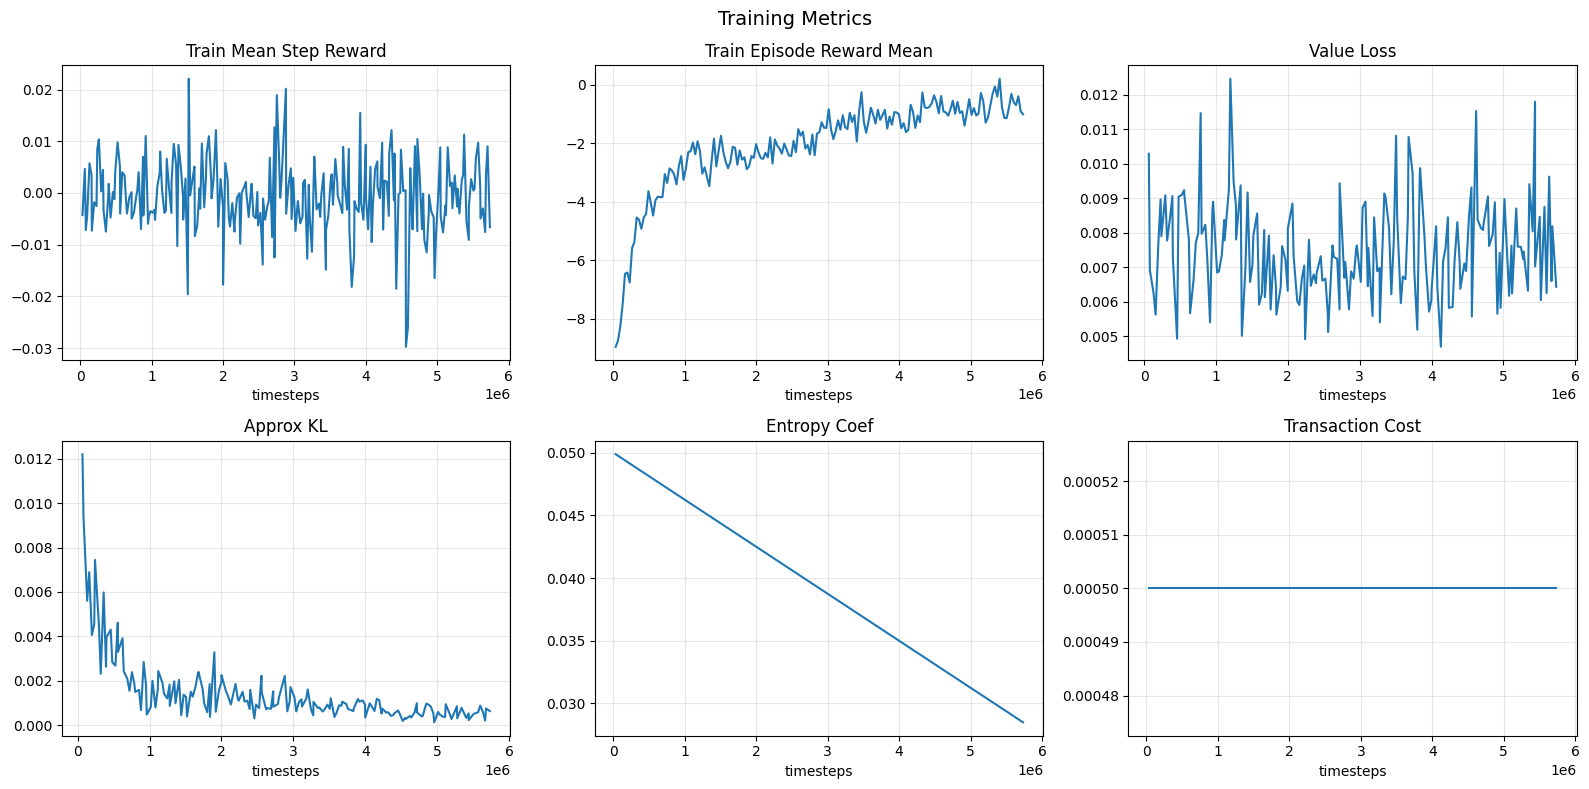

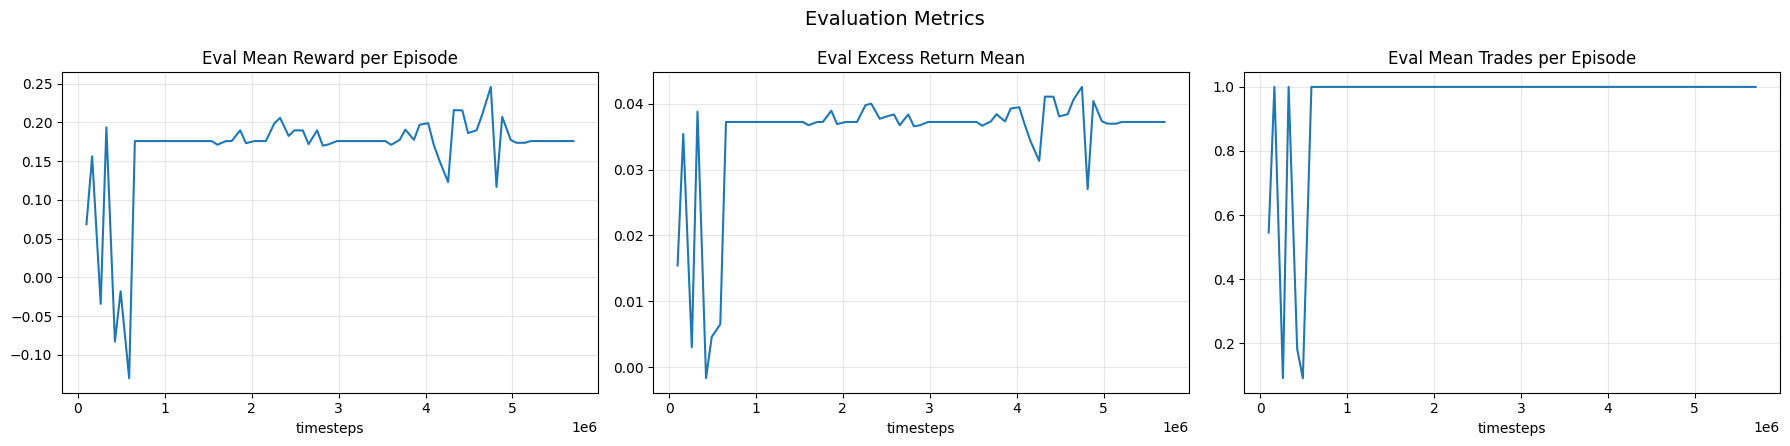

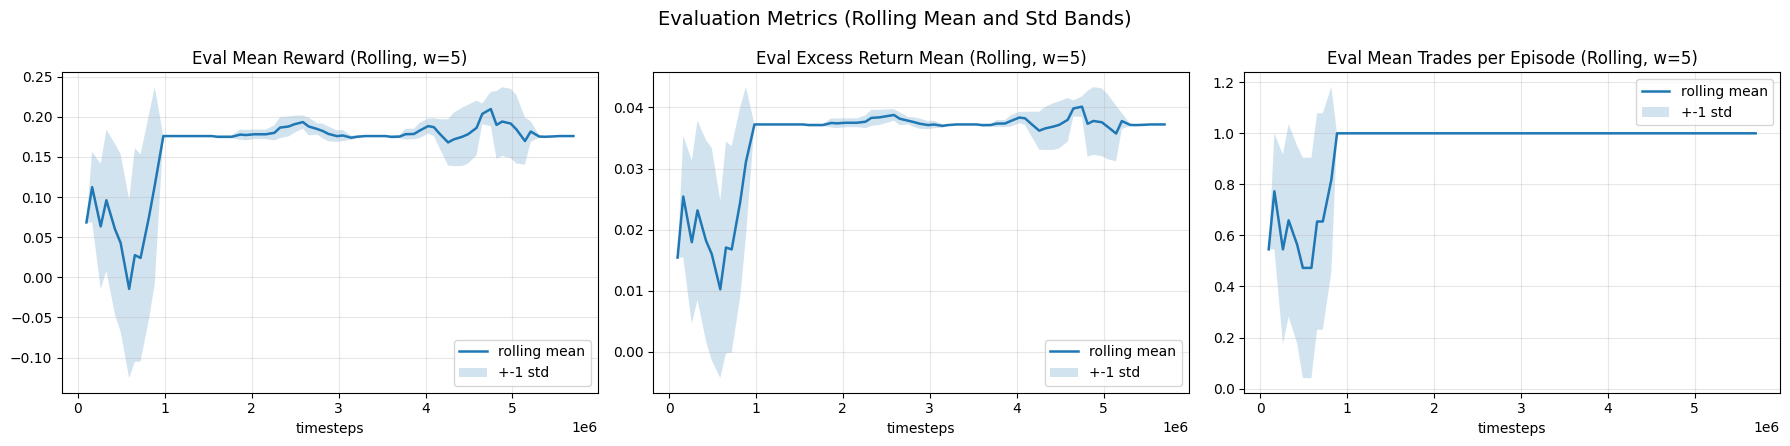

In [6]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

try:
    from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
except Exception as exc:
    raise RuntimeError(
        "TensorBoard event reader is unavailable. Install tensorboard in this environment."
    ) from exc


def _resolve_train_log_dir() -> Path:
    if TRAIN_LOG_DIR:
        return Path(TRAIN_LOG_DIR)
    base = PROJECT_ROOT / log_root
    # SB3 often writes under <tb_log_name>_0
    candidates = sorted(base.glob(f"{model_name}*"), key=lambda x: x.stat().st_mtime, reverse=True)
    if not candidates:
        raise FileNotFoundError(f"No train log directory found under {base} for model {model_name}")
    return candidates[0]


def _resolve_eval_log_dir() -> Path:
    if EVAL_LOG_DIR:
        return Path(EVAL_LOG_DIR)
    return PROJECT_ROOT / log_root / f"{model_name}_eval"


def _load_tb_scalars(log_dir: Path) -> dict[str, list[tuple[int, float, float]]]:
    event_files = sorted(log_dir.rglob("events.out.tfevents.*"))
    if not event_files:
        raise FileNotFoundError(f"No TensorBoard event files found in {log_dir}")

    series: dict[str, list[tuple[int, float, float]]] = {}
    for ef in event_files:
        acc = EventAccumulator(str(ef), size_guidance={"scalars": 0})
        try:
            acc.Reload()
        except Exception:
            continue
        for tag in acc.Tags().get("scalars", []):
            vals = acc.Scalars(tag)
            series.setdefault(tag, [])
            series[tag].extend((int(v.step), float(v.value), float(v.wall_time)) for v in vals)

    # sort + dedupe by step (keep latest wall_time per step)
    out: dict[str, list[tuple[int, float]]] = {}
    for tag, rows in series.items():
        rows.sort(key=lambda x: (x[0], x[2]))
        dedup: dict[int, tuple[float, float]] = {}
        for step, value, wall in rows:
            dedup[step] = (value, wall)
        out[tag] = sorted([(s, vw[0]) for s, vw in dedup.items()], key=lambda x: x[0])
    return out


def _plot_series(ax, tb_data: dict[str, list[tuple[int, float]]], tag: str, title: str):
    pts = tb_data.get(tag)
    if not pts:
        ax.set_title(f"{title} (missing)")
        ax.grid(True, alpha=0.3)
        return
    x = [p[0] for p in pts]
    y = [p[1] for p in pts]
    ax.plot(x, y, linewidth=1.5)
    ax.set_title(title)
    ax.set_xlabel("timesteps")
    ax.grid(True, alpha=0.3)


train_log_dir = _resolve_train_log_dir()
eval_log_dir = _resolve_eval_log_dir()
print(f"Train log dir: {train_log_dir}")
print(f"Eval log dir:  {eval_log_dir}")

tb = _load_tb_scalars(train_log_dir)

# Important training curves
train_tags = [
    ("custom/reward_mean", "Train Mean Step Reward"),
    ("custom/episode_reward_mean", "Train Episode Reward Mean"),
    ("train/value_loss", "Value Loss"),
    ("train/approx_kl", "Approx KL"),
    ("custom/ent_coef", "Entropy Coef"),
    ("custom/transaction_cost", "Transaction Cost"),
]

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
for ax, (tag, title) in zip(axes.flatten(), train_tags):
    _plot_series(ax, tb, tag, title)
fig.suptitle("Training Metrics", fontsize=14)
fig.tight_layout()
plt.show()

# Eval metrics from TensorBoard custom scalars
reward_pts = tb.get("custom/eval_episode_reward_mean", [])
excess_pts = tb.get("custom/eval_excess_return_mean", [])
trades_pts = tb.get("custom/eval_episode_trades_mean", [])

if reward_pts:
    eval_steps = np.asarray([p[0] for p in reward_pts], dtype=np.int64)
    eval_mean_reward = np.asarray([p[1] for p in reward_pts], dtype=np.float64)
else:
    eval_steps = np.array([], dtype=np.int64)
    eval_mean_reward = np.array([], dtype=np.float64)
    print("Warning: custom/eval_episode_reward_mean not found in TensorBoard logs.")

fig, axes = plt.subplots(1, 3, figsize=(18, 4.5))

if eval_steps.size > 0:
    axes[0].plot(eval_steps, eval_mean_reward, linewidth=1.5)
axes[0].set_title("Eval Mean Reward per Episode")
axes[0].set_xlabel("timesteps")
axes[0].grid(True, alpha=0.3)

if excess_pts:
    axes[1].plot([p[0] for p in excess_pts], [p[1] for p in excess_pts], linewidth=1.5)
axes[1].set_title("Eval Excess Return Mean")
axes[1].set_xlabel("timesteps")
axes[1].grid(True, alpha=0.3)

if trades_pts:
    axes[2].plot([p[0] for p in trades_pts], [p[1] for p in trades_pts], linewidth=1.5)
axes[2].set_title("Eval Mean Trades per Episode")
axes[2].set_xlabel("timesteps")
axes[2].grid(True, alpha=0.3)

fig.suptitle("Evaluation Metrics", fontsize=14)
fig.tight_layout()
plt.show()


# Rolling eval metrics with +/- 1 std bands
ROLLING_WINDOW = 5


def _rolling_mean_std(values: np.ndarray, window: int) -> tuple[np.ndarray, np.ndarray]:
    if values.size == 0:
        return values, values
    w = max(1, int(window))
    means = np.empty_like(values, dtype=np.float64)
    stds = np.empty_like(values, dtype=np.float64)
    for i in range(values.size):
        lo = max(0, i - w + 1)
        chunk = values[lo : i + 1]
        means[i] = float(np.mean(chunk))
        stds[i] = float(np.std(chunk))
    return means, stds


fig, axes = plt.subplots(1, 3, figsize=(18, 4.5))

# 1) Eval mean reward per episode (from TB)
if eval_steps.size > 0:
    rm, rs = _rolling_mean_std(eval_mean_reward, ROLLING_WINDOW)
    axes[0].plot(eval_steps, rm, linewidth=1.8, label="rolling mean")
    axes[0].fill_between(eval_steps, rm - rs, rm + rs, alpha=0.2, label="+-1 std")
axes[0].set_title(f"Eval Mean Reward (Rolling, w={ROLLING_WINDOW})")
axes[0].set_xlabel("timesteps")
axes[0].grid(True, alpha=0.3)
if eval_steps.size > 0:
    axes[0].legend()

# 2) Eval excess return mean (from TB)
if excess_pts:
    ex_steps = np.asarray([p[0] for p in excess_pts], dtype=np.int64)
    ex_vals = np.asarray([p[1] for p in excess_pts], dtype=np.float64)
    em, es = _rolling_mean_std(ex_vals, ROLLING_WINDOW)
    axes[1].plot(ex_steps, em, linewidth=1.8, label="rolling mean")
    axes[1].fill_between(ex_steps, em - es, em + es, alpha=0.2, label="+-1 std")
axes[1].set_title(f"Eval Excess Return Mean (Rolling, w={ROLLING_WINDOW})")
axes[1].set_xlabel("timesteps")
axes[1].grid(True, alpha=0.3)
if excess_pts:
    axes[1].legend()

# 3) Eval mean trades per episode (from TB)
if trades_pts:
    tr_steps = np.asarray([p[0] for p in trades_pts], dtype=np.int64)
    tr_vals = np.asarray([p[1] for p in trades_pts], dtype=np.float64)
    tm, ts = _rolling_mean_std(tr_vals, ROLLING_WINDOW)
    axes[2].plot(tr_steps, tm, linewidth=1.8, label="rolling mean")
    axes[2].fill_between(tr_steps, tm - ts, tm + ts, alpha=0.2, label="+-1 std")
axes[2].set_title(f"Eval Mean Trades per Episode (Rolling, w={ROLLING_WINDOW})")
axes[2].set_xlabel("timesteps")
axes[2].grid(True, alpha=0.3)
if trades_pts:
    axes[2].legend()

fig.suptitle("Evaluation Metrics (Rolling Mean and Std Bands)", fontsize=14)
fig.tight_layout()
plt.show()


## Checkpoint Selection
Select the PPO checkpoint to use for the rest of the notebook.


In [7]:
def list_ppo_checkpoints(checkpoint_dir: str) -> list[str]:
    if not os.path.isdir(checkpoint_dir):
        return []
    ckpts = []
    for fname in os.listdir(checkpoint_dir):
        if fname.startswith("ppo_") and fname.endswith("_steps.zip") or fname == ("best_model.zip"):
            ckpts.append(os.path.join(checkpoint_dir, fname))
    ckpts.sort(key=lambda p: os.path.getmtime(p))
    return ckpts


available_ckpts = list_ppo_checkpoints(ppo_checkpoint_dir)
if not available_ckpts:
    raise FileNotFoundError(f"No PPO checkpoints found in {ppo_checkpoint_dir}")

print("Available PPO checkpoints (oldest -> newest):")
for i, ckpt in enumerate(available_ckpts):
    rel = os.path.relpath(ckpt, PROJECT_ROOT)
    print(f"  [{i}] {rel}")

# Set this index manually before proceeding
CHECKPOINT_INDEX = 15

PPO_CHECKPOINT_PATH = available_ckpts[CHECKPOINT_INDEX]
print(f"Selected checkpoint index: {CHECKPOINT_INDEX}")
print(f"Selected PPO checkpoint: {PPO_CHECKPOINT_PATH}")


Available PPO checkpoints (oldest -> newest):
  [0] checkpoints\jepa6_ppo_final1\best_model.zip
  [1] checkpoints\jepa6_ppo_final1\ppo_320000_steps.zip
  [2] checkpoints\jepa6_ppo_final1\ppo_640000_steps.zip
  [3] checkpoints\jepa6_ppo_final1\ppo_960000_steps.zip
  [4] checkpoints\jepa6_ppo_final1\ppo_1280000_steps.zip
  [5] checkpoints\jepa6_ppo_final1\ppo_1600000_steps.zip
  [6] checkpoints\jepa6_ppo_final1\ppo_1920000_steps.zip
  [7] checkpoints\jepa6_ppo_final1\ppo_2240000_steps.zip
  [8] checkpoints\jepa6_ppo_final1\ppo_2560000_steps.zip
  [9] checkpoints\jepa6_ppo_final1\ppo_2880000_steps.zip
  [10] checkpoints\jepa6_ppo_final1\ppo_3200000_steps.zip
  [11] checkpoints\jepa6_ppo_final1\ppo_3520000_steps.zip
  [12] checkpoints\jepa6_ppo_final1\ppo_3840000_steps.zip
  [13] checkpoints\jepa6_ppo_final1\ppo_4160000_steps.zip
  [14] checkpoints\jepa6_ppo_final1\ppo_4480000_steps.zip
  [15] checkpoints\jepa6_ppo_final1\ppo_4800000_steps.zip
  [16] checkpoints\jepa6_ppo_final1\ppo_512000

In [8]:
@dataclass
class EvalConfig:
    annual_trading_days: int = 252
    regular_hours_only: bool = True
    timeframe: str = "15min"
    flat_threshold: float = 1e-3


def _timeframe_to_minutes(timeframe: str) -> int:
    tf = timeframe.strip().lower()
    if tf.endswith("min"):
        return int(tf[:-3])
    if tf.endswith("h"):
        return int(tf[:-1]) * 60
    raise ValueError(f"Unsupported timeframe: {timeframe}")


def annualization_factor(cfg: EvalConfig) -> float:
    minutes_per_day = 390 if cfg.regular_hours_only else 24 * 60
    minutes = _timeframe_to_minutes(cfg.timeframe)
    bars_per_day = max(1, minutes_per_day // minutes)
    return bars_per_day * cfg.annual_trading_days


def action_to_weight(action) -> float:
    if ACTION_MODE == "discrete_3":
        discrete_actions = np.array([-1.0, 0.0, 1.0], dtype=np.float32)
        idx = int(np.asarray(action).reshape(-1)[0])
        idx = int(np.clip(idx, 0, len(discrete_actions) - 1))
        w_t = float(discrete_actions[idx])
    else:
        w_t = float(np.clip(np.asarray(action).reshape(-1)[0], -1.0, 1.0))
    if not ALLOW_SHORT:
        w_t = max(0.0, w_t)
    return w_t


def compute_drawdown(equity: np.ndarray) -> float:
    if equity.size == 0:
        return float("nan")
    peak = np.maximum.accumulate(equity)
    drawdown = (equity - peak) / peak
    return float(np.min(drawdown))


def safe_sharpe(mean: float, std: float, ann_factor: float) -> float:
    if std <= 0 or np.isnan(std):
        return float("nan")
    return float(mean / std * np.sqrt(ann_factor))


def build_jepa_model(device: str, num_assets: int) -> JEPA:
    encoder_num_assets = num_assets if jepa_cfg.get("use_asset_embeddings", True) else None

    jepa_context_encoder = PatchTSTEncoder(
        patch_len=jepa_cfg["patch_len"],
        d_model=jepa_cfg["d_model"],
        n_features=jepa_cfg["n_features"],
        n_time_features=jepa_cfg["n_time_features"],
        nhead=jepa_cfg["nhead"],
        num_layers=jepa_cfg["num_layers"],
        dim_ff=jepa_cfg["dim_ff"],
        dropout=jepa_cfg["dropout"],
        add_cls=jepa_cfg.get("add_cls", True),
        pooling=jepa_cfg["pooling"],
        pred_len=jepa_cfg["pred_len"],
        num_assets=encoder_num_assets,
    )
    jepa_target_encoder = copy.deepcopy(jepa_context_encoder)

    jepa_model = JEPA(
        jepa_context_encoder,
        jepa_target_encoder,
        d_model=jepa_cfg["d_model"],
        ema_tau_min=jepa_cfg["ema_tau_min"],
        ema_tau_max=jepa_cfg["ema_tau_max"],
    )

    for param in jepa_model.parameters():
        param.requires_grad = False
    jepa_model.eval()
    return jepa_model.to(device)


def extract_jepa_state_dict_from_ppo_zip(model_path: str) -> Dict[str, torch.Tensor]:
    with zipfile.ZipFile(model_path, "r") as zf:
        with zf.open("policy.pth", "r") as f:
            policy_state = torch.load(io.BytesIO(f.read()), map_location="cpu")

    prefix = "features_extractor.jepa_model."
    jepa_state = {}
    for k, v in policy_state.items():
        if k.startswith(prefix):
            jepa_state[k[len(prefix):]] = v
    if not jepa_state:
        raise RuntimeError("No JEPA weights found in PPO zip policy state.")
    return jepa_state


def load_ppo_model(model_path: str, device: str, policy_kwargs: Dict) -> PPOWithJEPA:
    try:
        print("Loading PPO (and embedded JEPA) directly from PPO zip...")
        return PPOWithJEPA.load(model_path, device=device)
    except Exception as exc:
        print(f"Primary PPO load failed ({exc}); retrying with custom policy_kwargs and JEPA weights from PPO zip.")

        fx_kwargs = policy_kwargs.get("features_extractor_kwargs", {})
        jepa_model = fx_kwargs.get("jepa_model")
        if jepa_model is None:
            raise RuntimeError("Fallback requires policy_kwargs.features_extractor_kwargs.jepa_model")

        jepa_state = extract_jepa_state_dict_from_ppo_zip(model_path)
        missing, unexpected = jepa_model.load_state_dict(jepa_state, strict=False)
        if missing:
            print(f"Missing keys when loading JEPA from PPO zip: {missing}")
        if unexpected:
            print(f"Unexpected keys when loading JEPA from PPO zip: {unexpected}")

        return PPOWithJEPA.load(model_path, device=device, custom_objects={"policy_kwargs": policy_kwargs})


def eval_asset(model: PPOWithJEPA, dataset: Dataset_Finance_MultiAsset, asset_id: str, cfg: EvalConfig) -> Dict[str, float]:
    asset_idx = dataset.asset_id_to_idx.get(asset_id, -1)
    X = dataset.data_x[asset_id]
    dates = dataset.dates[asset_id]
    ohlcv = dataset.ohlcv[asset_id]

    seq_len = dataset.seq_len
    pred_len = dataset.pred_len
    n_steps = len(X) - seq_len - pred_len
    if n_steps <= 0:
        return {}

    w_prev = 0.0
    wealth = 1.0
    expects_asset_id = True
    obs_space = getattr(model.policy, "observation_space", None)
    if hasattr(obs_space, "spaces"):
        expects_asset_id = "asset_id" in obs_space.spaces
    else:
        expects_asset_id = INCLUDE_ASSET_ID
    rewards, asset_returns, positions, turnovers, equity = [], [], [], [], []

    for cursor in range(n_steps):
        x_context = X[cursor : cursor + seq_len].astype(np.float32)
        t_context = dates[cursor : cursor + seq_len].astype(np.float32)
        x_target = X[cursor + seq_len : cursor + seq_len + pred_len].astype(np.float32)
        t_target = dates[cursor + seq_len : cursor + seq_len + pred_len].astype(np.float32)

        obs = {
            "x_context": x_context,
            "t_context": t_context,
            "x_target": x_target,
            "t_target": t_target,
            "w_prev": np.array([w_prev], dtype=np.float32),
        }
        if expects_asset_id:
            obs["asset_id"] = np.int64(asset_idx)
        if INCLUDE_WEALTH:
            obs["wealth_feats"] = np.array([np.log(wealth)], dtype=np.float32)

        action, _ = model.predict(obs, deterministic=DETERMINISTIC)
        w_t = action_to_weight(action)

        close_t = float(ohlcv[cursor + seq_len - 1][3])
        close_tp1 = float(ohlcv[cursor + seq_len][3])
        r_tp1 = float(np.log(close_tp1 / close_t))

        turnover = abs(w_t - w_prev)
        cost = min(TRANSACTION_COST * turnover, 0.99)
        reward = w_t * r_tp1 + float(np.log1p(-cost))
        wealth *= float(np.exp(reward))

        rewards.append(reward)
        asset_returns.append(r_tp1)
        positions.append(w_t)
        turnovers.append(turnover)
        equity.append(wealth)
        w_prev = w_t

    rewards = np.asarray(rewards, dtype=np.float64)
    asset_returns = np.asarray(asset_returns, dtype=np.float64)
    positions = np.asarray(positions, dtype=np.float64)
    turnovers = np.asarray(turnovers, dtype=np.float64)
    equity = np.asarray(equity, dtype=np.float64)

    ann_factor = annualization_factor(cfg)
    mean_reward = float(np.mean(rewards)) if rewards.size else float("nan")
    std_reward = float(np.std(rewards, ddof=1)) if rewards.size > 1 else float("nan")

    total_log_return = float(np.sum(rewards)) if rewards.size else float("nan")
    total_return = float(np.exp(total_log_return) - 1.0) if rewards.size else float("nan")
    annualized_return = float(np.exp(mean_reward * ann_factor) - 1.0) if rewards.size else float("nan")
    annualized_vol = float(std_reward * np.sqrt(ann_factor)) if rewards.size > 1 else float("nan")
    sharpe = safe_sharpe(mean_reward, std_reward, ann_factor)

    downside = rewards[rewards < 0]
    downside_std = float(np.std(downside, ddof=1)) if downside.size > 1 else float("nan")
    sortino = safe_sharpe(mean_reward, downside_std, ann_factor)

    max_drawdown = compute_drawdown(equity)
    calmar = float(annualized_return / abs(max_drawdown)) if max_drawdown < 0 else float("nan")

    win_rate = float(np.mean(rewards > 0)) if rewards.size else float("nan")
    avg_turnover = float(np.mean(turnovers)) if turnovers.size else float("nan")
    total_turnover = float(np.sum(turnovers)) if turnovers.size else float("nan")
    avg_position = float(np.mean(positions)) if positions.size else float("nan")
    pos_std = float(np.std(positions, ddof=1)) if positions.size > 1 else float("nan")
    abs_pos = float(np.mean(np.abs(positions))) if positions.size else float("nan")

    flat_mask = np.abs(positions) <= cfg.flat_threshold
    long_mask = positions > cfg.flat_threshold
    short_mask = positions < -cfg.flat_threshold
    flat_frac = float(np.mean(flat_mask)) if positions.size else float("nan")
    long_frac = float(np.mean(long_mask)) if positions.size else float("nan")
    short_frac = float(np.mean(short_mask)) if positions.size else float("nan")

    trade_count = int(np.sum(np.abs(np.diff(positions)) > cfg.flat_threshold)) if positions.size > 1 else 0

    bh_mean = float(np.mean(asset_returns)) if asset_returns.size else float("nan")
    bh_std = float(np.std(asset_returns, ddof=1)) if asset_returns.size > 1 else float("nan")
    bh_total_return = float(np.exp(np.sum(asset_returns)) - 1.0) if asset_returns.size else float("nan")
    bh_annualized_return = float(np.exp(bh_mean * ann_factor) - 1.0) if asset_returns.size else float("nan")
    bh_annualized_vol = float(bh_std * np.sqrt(ann_factor)) if asset_returns.size > 1 else float("nan")
    bh_sharpe = safe_sharpe(bh_mean, bh_std, ann_factor)

    print(f"{asset_id}: total return: {total_return:.4f}, bh return: {bh_total_return:.4f}")

    return {
        "asset_id": asset_id,
        "steps": int(n_steps),
        "total_return": total_return,
        "annualized_return": annualized_return,
        "annualized_volatility": annualized_vol,
        "sharpe": sharpe,
        "sortino": sortino,
        "max_drawdown": max_drawdown,
        "calmar": calmar,
        "avg_reward": mean_reward,
        "reward_volatility": std_reward,
        "win_rate": win_rate,
        "avg_turnover": avg_turnover,
        "total_turnover": total_turnover,
        "avg_position": avg_position,
        "position_std": pos_std,
        "avg_abs_position": abs_pos,
        "long_frac": long_frac,
        "short_frac": short_frac,
        "flat_frac": flat_frac,
        "trade_count": trade_count,
        "bh_total_return": bh_total_return,
        "bh_annualized_return": bh_annualized_return,
        "bh_annualized_volatility": bh_annualized_vol,
        "bh_sharpe": bh_sharpe,
    }



In [9]:
def _resolve_project_path(path_value: str | None) -> str | None:
    if path_value is None:
        return None
    p = Path(path_value)
    if p.is_absolute():
        return str(p)
    return str((PROJECT_ROOT / p).resolve())



ticker_list_path = paths_cfg.get("ticker_list_path")
if not ticker_list_path:
    raise ValueError("Config is missing paths.ticker_list_path")

# Build dataset from the same config used in training
tickers_path = PROJECT_ROOT / ticker_list_path
tickers = load_tickers(str(tickers_path))
if not tickers:
    raise RuntimeError(f"No tickers loaded from {tickers_path}")

dataset_kwargs = {
    "root_path": _resolve_project_path(dataset_cfg["root_path"]),
    "data_path": dataset_cfg["data_path"],
    "start_date": dataset_cfg.get("start_date"),
    "split": "val",
    "size": [dataset_cfg["context_len"], dataset_cfg["target_len"]],
    "use_time_features": dataset_cfg.get("use_time_features", True),
    "rolling_window": dataset_cfg["rolling_window"],
    "train_split": dataset_cfg["train_split"],
    "test_split": dataset_cfg["test_split"],
    "regular_hours_only": dataset_cfg.get("regular_hours_only", True),
    "timeframe": dataset_cfg.get("timeframe", "15min"),
    "tickers": tickers,
}

asset_universe = load_asset_universe_from_checkpoint(JEPA_CHECKPOINT_PATH)
if asset_universe:
    dataset_kwargs["asset_universe"] = asset_universe

dataset_kwargs["tickers"] = tickers
print(f"Loaded {len(tickers)} tickers from {tickers_path}")
print(f"tickers: {tickers}")

print("Loading evaluation dataset...")
test_dataset = Dataset_Finance_MultiAsset(**dataset_kwargs)
if not test_dataset.asset_ids:
    raise RuntimeError("No assets found in the validation dataset.")

if MAX_ASSETS is not None:
    test_dataset.asset_ids = test_dataset.asset_ids[: int(MAX_ASSETS)]

print(f"Assets to evaluate: {len(test_dataset.asset_ids)}")


Loaded 11 tickers from C:\python\koulu\Gradu\configs\assets\tickers1.txt
tickers: ['AMZN', 'KO', 'DIS', 'V', 'SPY', 'NKE', 'CSCO', 'JPM', 'CAT', 'AMGN', 'DIA']
Loading evaluation dataset...


C:\Users\ollik\AppData\Local\Temp\ipykernel_70436\1901959863.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location="cpu")


[Dataset_Finance_MultiAsset] Global date splits: train_end=2024-08-01 15:15:00+00:00 val_end=2025-04-29 16:30:00+00:00 n_dates=33178 n_train=23224 n_val=4978 n_test=4976
Assets to evaluate: 11


In [10]:
if PPO_CHECKPOINT_PATH is None:
    raise RuntimeError("Select PPO_CHECKPOINT_PATH in the Checkpoint Selection cell first.")

device = "cuda" if torch.cuda.is_available() else "cpu"
num_asset_ids = int(getattr(test_dataset, "num_asset_ids", len(test_dataset.asset_ids)))

print("Loading JEPA model...")
jepa_model = build_jepa_model(device, num_assets=num_asset_ids)

policy_kwargs = dict(
    features_extractor_class=JEPAAuxFeatureExtractor,
    features_extractor_kwargs=dict(
        jepa_model=jepa_model,
        embedding_dim=jepa_cfg["d_model"],
        patch_len=jepa_cfg["patch_len"],
        patch_stride=jepa_cfg["patch_stride"],
        use_obs_targets=True,
        target_len=test_dataset.pred_len,
    ),
    net_arch=dict(pi=[256, 256], vf=[256, 256]),
)

print(f"Loading PPO model from {PPO_CHECKPOINT_PATH}...")
model = load_ppo_model(PPO_CHECKPOINT_PATH, device=device, policy_kwargs=policy_kwargs)
model.policy.eval()


Loading JEPA model...
Loading PPO model from C:\python\koulu\Gradu\checkpoints\jepa6_ppo_final1\ppo_4800000_steps.zip...
Loading PPO (and embedded JEPA) directly from PPO zip...


c:\Users\ollik\miniconda3\envs\.graduenv\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


MultiInputActorCriticPolicy(
  (features_extractor): JEPAAuxFeatureExtractor(
    (jepa_model): JEPA(
      (context_enc): PatchTSTEncoder(
        (proj_price): Linear(in_features=72, out_features=192, bias=True)
        (proj_time): Linear(in_features=32, out_features=192, bias=True)
        (posenc): PositionalEncoding()
        (encoder): TransformerEncoder(
          (layers): ModuleList(
            (0-3): 4 x TransformerEncoderLayer(
              (self_attn): MultiheadAttention(
                (out_proj): NonDynamicallyQuantizableLinear(in_features=192, out_features=192, bias=True)
              )
              (linear1): Linear(in_features=192, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (linear2): Linear(in_features=768, out_features=192, bias=True)
              (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
              (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
              (dropou

In [11]:
eval_cfg = EvalConfig(
    annual_trading_days=252,
    regular_hours_only=dataset_kwargs.get("regular_hours_only", True),
    timeframe=dataset_kwargs.get("timeframe", "15min"),
)

results: List[Dict[str, float]] = []
for idx, asset_id in enumerate(test_dataset.asset_ids, start=1):
    print(f"[{idx}/{len(test_dataset.asset_ids)}] Evaluating {asset_id}...")
    metrics = eval_asset(model, test_dataset, asset_id, eval_cfg)
    if metrics:
        results.append(metrics)

if not results:
    raise RuntimeError("No evaluation results produced.")

df = pd.DataFrame(results).sort_values("asset_id")
df.head(11)


[1/11] Evaluating AMZN...
AMZN: total return: -0.0659, bh return: 0.1048
[2/11] Evaluating KO...
KO: total return: 0.0161, bh return: 0.0034
[3/11] Evaluating DIS...
DIS: total return: 0.0005, bh return: 0.0073
[4/11] Evaluating V...
V: total return: -0.1698, bh return: 0.2366
[5/11] Evaluating SPY...
SPY: total return: 0.0134, bh return: -0.0169
[6/11] Evaluating NKE...
NKE: total return: 0.3693, bh return: -0.3199
[7/11] Evaluating CSCO...
CSCO: total return: -0.0753, bh return: 0.1300
[8/11] Evaluating JPM...
JPM: total return: -0.1176, bh return: 0.0931
[9/11] Evaluating CAT...
CAT: total return: 0.0787, bh return: -0.1302
[10/11] Evaluating AMGN...
AMGN: total return: 0.1580, bh return: -0.1467
[11/11] Evaluating DIA...
DIA: total return: 0.0195, bh return: -0.0318


,asset_id,steps,total_return,annualized_return,annualized_volatility,sharpe,sortino,max_drawdown,calmar,avg_reward,...,position_std,avg_abs_position,long_frac,short_frac,flat_frac,trade_count,bh_total_return,bh_annualized_return,bh_annualized_volatility,bh_sharpe
9,AMGN,4416,0.158015,0.243176,0.304026,0.715955,1.008004,-0.237782,1.022685,3.322179e-05,...,0.170307,0.970109,0.0,0.970109,0.029891,1,-0.146664,-0.209680,0.305772,-0.769582
0,AMZN,4417,-0.065922,-0.096209,0.360720,-0.280432,-0.332486,-0.292885,-0.328488,-1.543918e-05,...,0.153763,0.975775,0.0,0.975775,0.024225,1,0.104821,0.159358,0.362985,0.407364
8,CAT,4416,0.078725,0.118998,0.349498,0.321701,0.373870,-0.217439,0.547274,1.716026e-05,...,0.191323,0.961957,0.0,0.961957,0.038043,1,-0.130198,-0.186948,0.354228,-0.584258
6,CSCO,4416,-0.075308,-0.109671,0.229442,-0.506291,-0.541273,-0.206610,-0.530813,-1.772965e-05,...,0.304334,0.896739,0.0,0.896739,0.103261,1,0.130017,0.198842,0.235809,0.769079
10,DIA,4408,0.019474,0.029082,0.194187,0.147626,0.166752,-0.111025,0.261940,4.375301e-06,...,0.172322,0.969374,0.0,0.969374,0.030626,1,-0.031810,-0.046914,0.195193,-0.246168
2,DIS,4370,0.000474,0.000710,0.306168,0.002319,0.002537,-0.264791,0.002682,1.083664e-07,...,0.121977,0.984897,0.0,0.984897,0.015103,1,0.007318,0.010991,0.306695,0.035642
7,JPM,4416,-0.117554,-0.169350,0.321762,-0.576659,-0.628317,-0.281130,-0.602391,-2.831914e-05,...,0.188008,0.963315,0.0,0.963315,0.036685,1,0.093133,0.141246,0.323585,0.408302
1,KO,4416,0.016120,0.024010,0.186979,0.126895,0.154500,-0.183183,0.131073,3.621271e-06,...,0.151662,0.976449,0.0,0.976449,0.023551,1,0.003404,0.005055,0.187840,0.026841
5,NKE,4416,0.369329,0.594175,0.415780,1.121641,1.351225,-0.165573,3.588591,7.117772e-05,...,0.213806,0.951993,0.0,0.951993,0.048007,1,-0.319929,-0.435633,0.419046,-1.365125
4,SPY,4417,0.013449,0.020014,0.212316,0.093334,0.108924,-0.121801,0.164316,3.024459e-06,...,0.130892,0.982567,0.0,0.982567,0.017433,1,-0.016873,-0.024926,0.213149,-0.118423


In [12]:
ret_analysis = df[["asset_id", "total_return", "bh_total_return", "sharpe", "bh_sharpe"]].copy()
ret_analysis["ret_diff"] = ret_analysis["total_return"] - ret_analysis["bh_total_return"]
ret_analysis["sharpe_diff"] = ret_analysis["sharpe"] - ret_analysis["bh_sharpe"]
ret_analysis

,asset_id,total_return,bh_total_return,sharpe,bh_sharpe,ret_diff,sharpe_diff
9,AMGN,0.158015,-0.146664,0.715955,-0.769582,0.304679,1.485538
0,AMZN,-0.065922,0.104821,-0.280432,0.407364,-0.170743,-0.687796
8,CAT,0.078725,-0.130198,0.321701,-0.584258,0.208923,0.905959
6,CSCO,-0.075308,0.130017,-0.506291,0.769079,-0.205325,-1.275371
10,DIA,0.019474,-0.031810,0.147626,-0.246168,0.051283,0.393794
2,DIS,0.000474,0.007318,0.002319,0.035642,-0.006844,-0.033323
7,JPM,-0.117554,0.093133,-0.576659,0.408302,-0.210687,-0.984961
1,KO,0.016120,0.003404,0.126895,0.026841,0.012716,0.100053
5,NKE,0.369329,-0.319929,1.121641,-1.365125,0.689258,2.486766
4,SPY,0.013449,-0.016873,0.093334,-0.118423,0.030321,0.211756


## Trade Visualization
Plot each asset price path with buy/sell markers inferred from position changes.


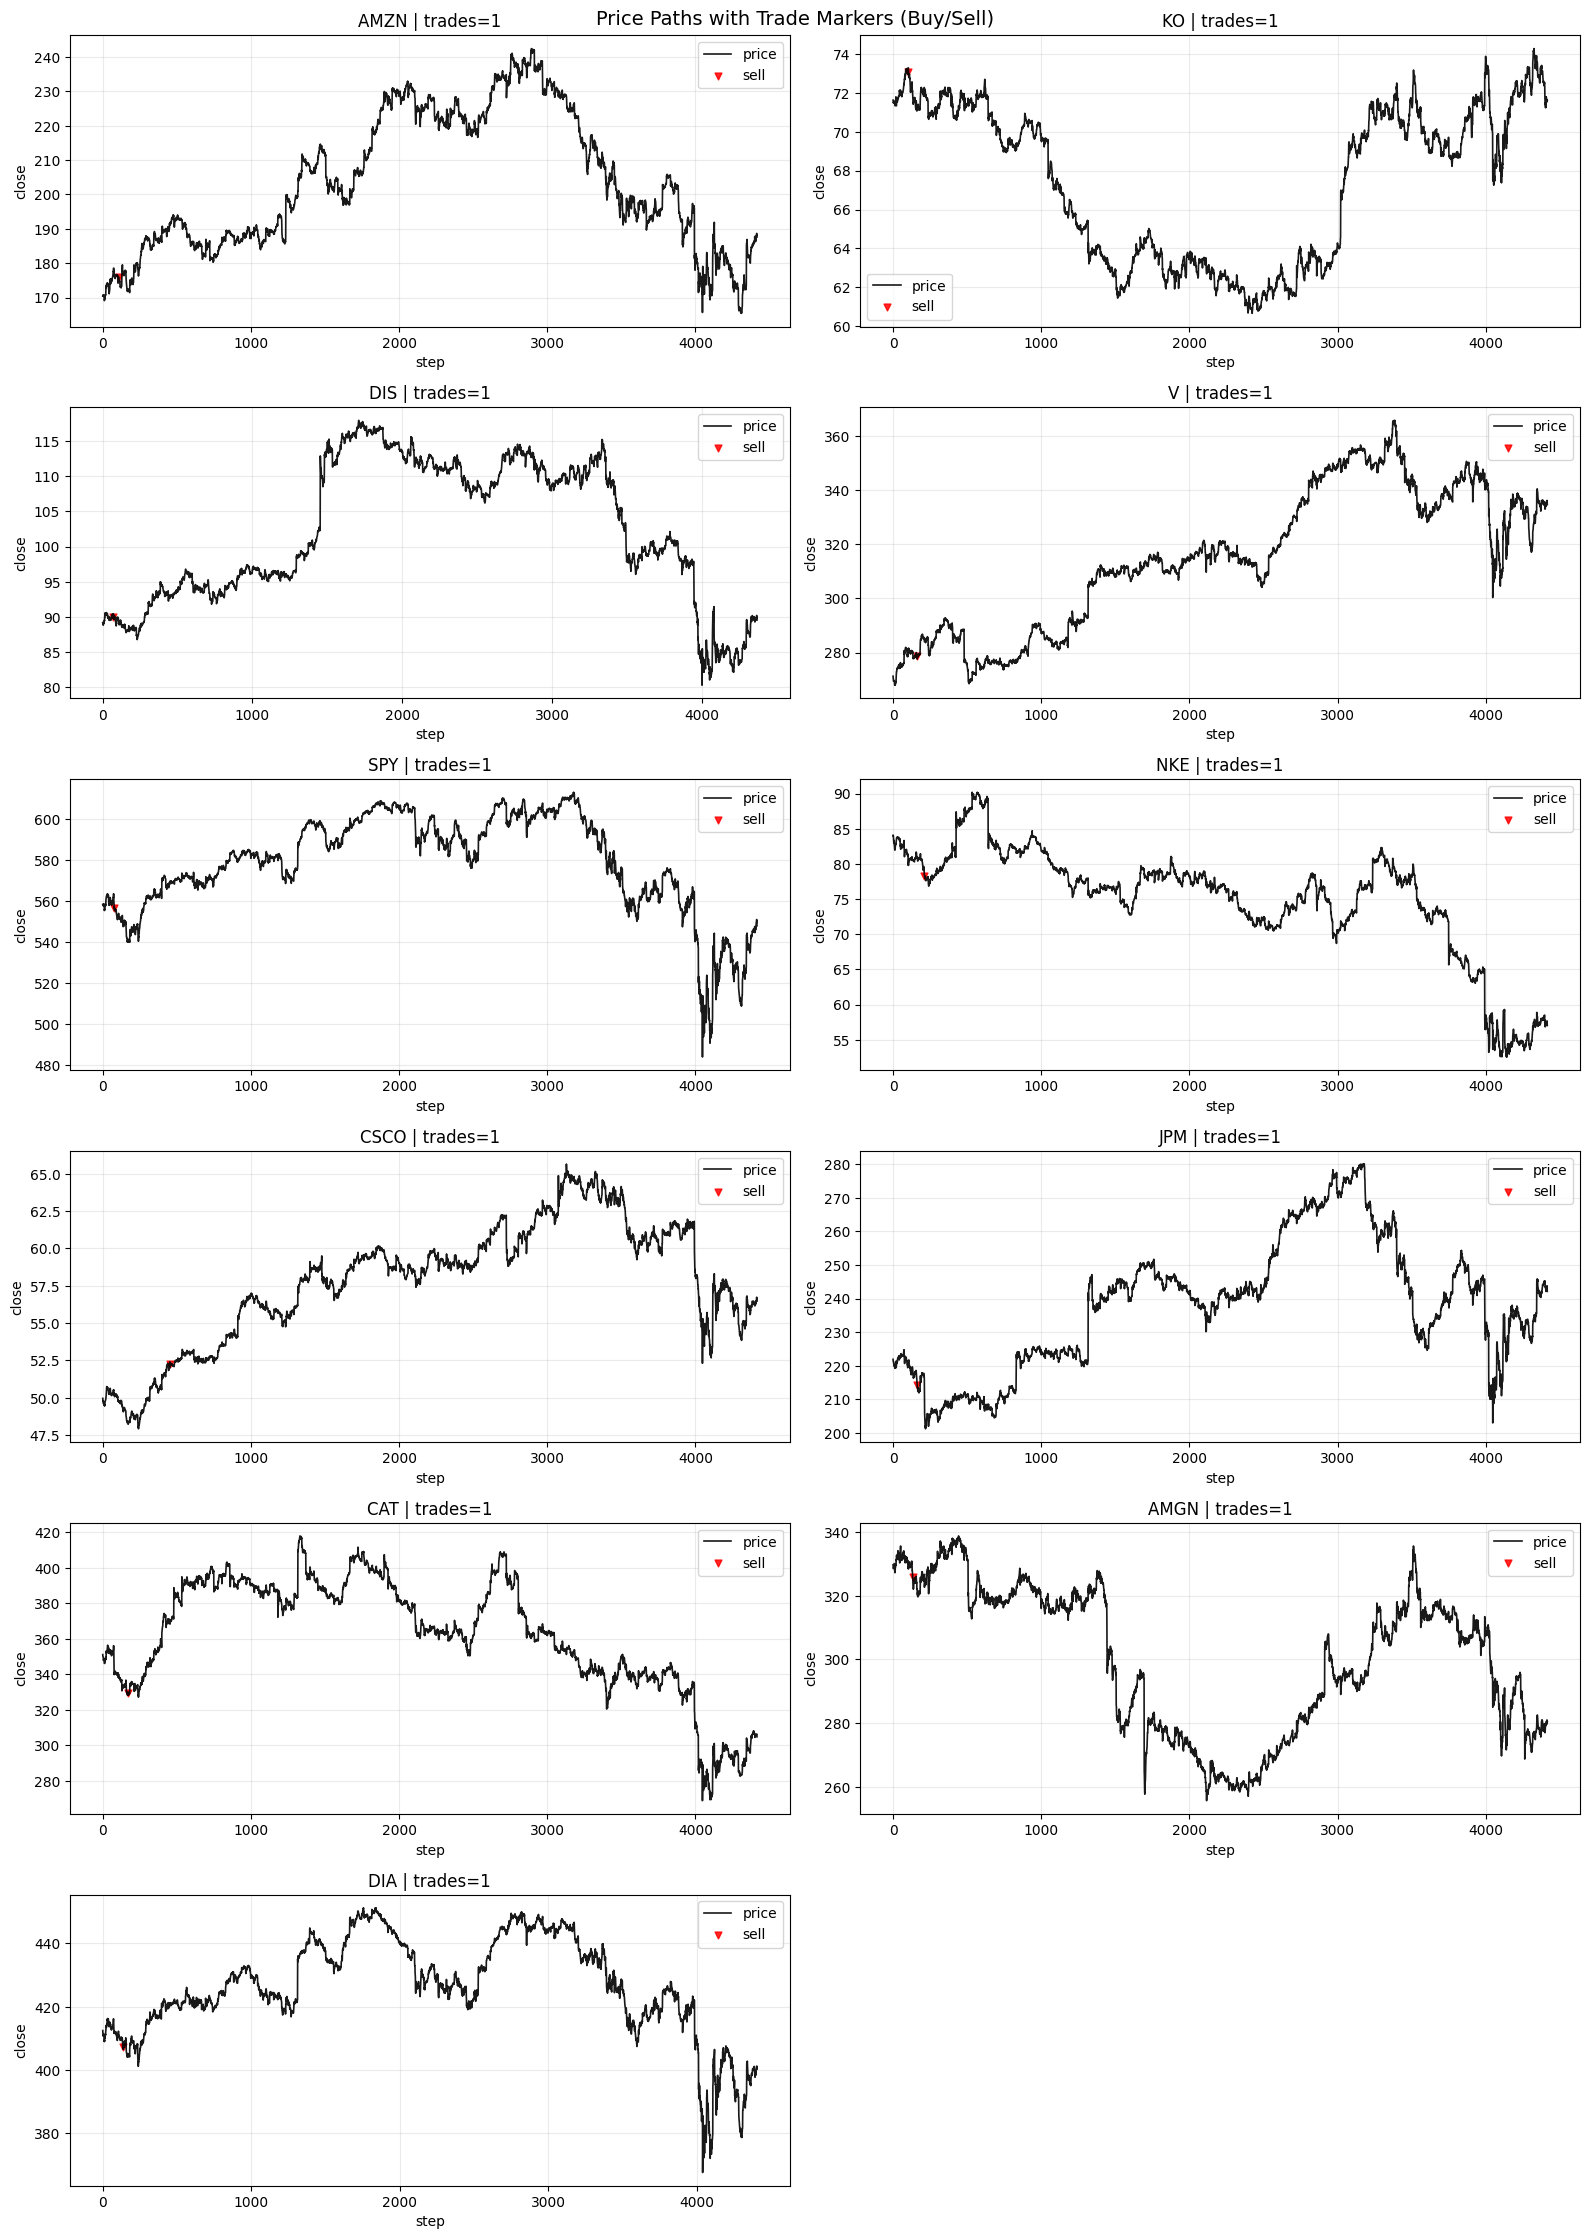

In [13]:
# Trade visualization settings
TRADE_PLOT_MAX_ASSETS = None   # set int to limit plotted assets
TRADE_EPS = 1e-8
TRADE_PLOT_COLS = 2


def simulate_asset_trades(model: PPOWithJEPA, dataset: Dataset_Finance_MultiAsset, asset_id: str):
    asset_idx = dataset.asset_id_to_idx.get(asset_id, -1)
    X = dataset.data_x[asset_id]
    dates = dataset.dates[asset_id]
    ohlcv = dataset.ohlcv[asset_id]

    seq_len = dataset.seq_len
    pred_len = dataset.pred_len
    n_steps = len(X) - seq_len - pred_len
    if n_steps <= 0:
        return pd.DataFrame()

    obs_space = getattr(model.policy, 'observation_space', None)
    expects_asset_id = INCLUDE_ASSET_ID
    if hasattr(obs_space, 'spaces'):
        expects_asset_id = 'asset_id' in obs_space.spaces

    rows = []
    w_prev = 0.0
    wealth = 1.0

    for cursor in range(n_steps):
        x_context = X[cursor : cursor + seq_len].astype(np.float32)
        t_context = dates[cursor : cursor + seq_len].astype(np.float32)
        x_target = X[cursor + seq_len : cursor + seq_len + pred_len].astype(np.float32)
        t_target = dates[cursor + seq_len : cursor + seq_len + pred_len].astype(np.float32)

        obs = {
            'x_context': x_context,
            't_context': t_context,
            'x_target': x_target,
            't_target': t_target,
            'w_prev': np.array([w_prev], dtype=np.float32),
        }
        if expects_asset_id:
            obs['asset_id'] = np.int64(asset_idx)
        if INCLUDE_WEALTH:
            obs['wealth_feats'] = np.array([np.log(wealth)], dtype=np.float32)

        action, _ = model.predict(obs, deterministic=DETERMINISTIC)
        w_t = action_to_weight(action)

        close_t = float(ohlcv[cursor + seq_len - 1][3])
        close_tp1 = float(ohlcv[cursor + seq_len][3])
        r_tp1 = float(np.log(close_tp1 / close_t))

        turnover = abs(w_t - w_prev)
        cost = min(TRANSACTION_COST * turnover, 0.99)
        reward = w_t * r_tp1 + float(np.log1p(-cost))
        wealth *= float(np.exp(reward))

        delta = w_t - w_prev
        trade_type = 'buy' if delta > TRADE_EPS else ('sell' if delta < -TRADE_EPS else 'hold')

        rows.append({
            'asset_id': asset_id,
            'step': cursor,
            'price': close_t,
            'position': w_t,
            'delta_position': delta,
            'trade_type': trade_type,
            'turnover': turnover,
        })

        w_prev = w_t

    return pd.DataFrame(rows)


assets_to_plot = list(test_dataset.asset_ids)
if TRADE_PLOT_MAX_ASSETS is not None:
    assets_to_plot = assets_to_plot[: int(TRADE_PLOT_MAX_ASSETS)]

trade_frames = []
for asset_id in assets_to_plot:
    tdf = simulate_asset_trades(model, test_dataset, asset_id)
    if not tdf.empty:
        trade_frames.append(tdf)

if not trade_frames:
    raise RuntimeError('No trade data available to plot.')

n = len(trade_frames)
ncols = max(1, int(TRADE_PLOT_COLS))
nrows = int(np.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(8 * ncols, 3.8 * nrows), squeeze=False)

for i, tdf in enumerate(trade_frames):
    ax = axes[i // ncols][i % ncols]
    asset_id = tdf['asset_id'].iloc[0]

    ax.plot(tdf['step'], tdf['price'], linewidth=1.2, color='black', alpha=0.9, label='price')

    buys = tdf[tdf['trade_type'] == 'buy']
    sells = tdf[tdf['trade_type'] == 'sell']

    if not buys.empty:
        ax.scatter(buys['step'], buys['price'], marker='^', s=24, color='green', alpha=0.85, label='buy')
    if not sells.empty:
        ax.scatter(sells['step'], sells['price'], marker='v', s=24, color='red', alpha=0.85, label='sell')

    ax.set_title(f"{asset_id} | trades={int((tdf['trade_type']!='hold').sum())}")
    ax.set_xlabel('step')
    ax.set_ylabel('close')
    ax.grid(True, alpha=0.25)
    ax.legend(loc='best')

# Hide unused axes
for j in range(n, nrows * ncols):
    axes[j // ncols][j % ncols].axis('off')

fig.suptitle('Price Paths with Trade Markers (Buy/Sell)', fontsize=14)
fig.tight_layout()
plt.show()


In [14]:
# Save outputs
os.makedirs(PROJECT_ROOT / log_root, exist_ok=True)
metrics_path = PROJECT_ROOT / log_root / f"{model_name}_test_metrics.csv"
summary_path = PROJECT_ROOT / log_root / f"{model_name}_test_summary.csv"

df.to_csv(metrics_path, index=False)
summary = df.drop(columns=["asset_id"]).agg(["mean", "median"])
summary.to_csv(summary_path)

print(f"Saved per-asset metrics to {metrics_path}")
print(f"Saved summary to {summary_path}")
summary


PermissionError: [Errno 13] Permission denied: 'C:\\python\\koulu\\Gradu\\logs\\jepa6_ppo_final1_test_metrics.csv'